In [ ]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

#Unzipping Dataset
#!cp -r "/content/drive/MyDrive/dataset" .

In [ ]:
#Function to pretty print the directory structure
import os
def list_files(startpath):
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)

list_files('dataset')

In [ ]:
#Libraries set up

#Visualization
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#CNN Architecture
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten, GlobalAvgPool2D
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

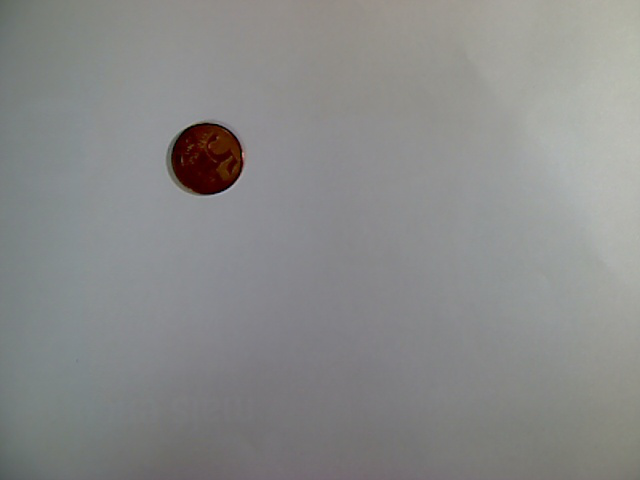

In [ ]:
#Looking at an example image (Raw)
image = Image.open('/content/drive/MyDrive/dataset/training_set/five/5_1477146390.jpg')
display(image)

The Size of the Raw Images without Resizing: (640, 480)

Resized Image:-



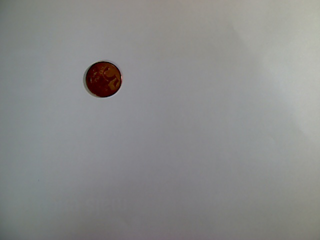


The Size of the Input Images after Resizing: (320, 240)


In [ ]:
#Size of the image
print('The Size of the Raw Images without Resizing: {}\n\nResized Image:-\n'.format(image.size))

factor = 2 # Size Reduction Factor
size = image.size[0] / factor
image.thumbnail((size,size)) #The thumnail method of the PIL.Image object ensures that aspect ratio is preserved while reszing.

display(image)

target_hieght, target_width = image.size #Extracting Target Size

print('\nThe Size of the Input Images after Resizing: {}'.format(image.size))

In [ ]:
#Data Augmentation and Pre-Processing

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range=90,  
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

#Training Set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/training_set', 
                                                 target_size = (240, 320), 
                                                 batch_size = 32, 
                                                 class_mode='categorical')

#Test Set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/test_set', 
                                            target_size = (240, 320), 
                                            batch_size = 32, 
                                            class_mode = 'categorical')

Found 2534 images belonging to 5 classes.
Found 526 images belonging to 5 classes.


In [ ]:
#CNN Architecture
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten, GlobalAvgPool2D
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras
model = Sequential()


# CNN network
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(target_width, target_hieght, 3)) )
model.add( MaxPool2D(2) )

model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(128, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(256, 3, activation='relu', padding='same') )

# Transition between CNN and MLP
model.add( GlobalAvgPool2D() )

# MLP network
model.add( Dense(256, activation='relu') )

model.add( Dense(5, activation='softmax') )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 80, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 40, 64)       0

In [ ]:
#Setting up Training Scheme
optm = Adam(learning_rate = 1e-3) #Loss fuction

model.compile(optimizer = optm, loss = 'categorical_crossentropy', metrics = ['acc']) 

#Setting Up callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.1, verbose=True),
    ModelCheckpoint('best_model', save_best_only=True),
]

In [ ]:
#Training 
history = model.fit(training_set, 
                    epochs=30, 
                    validation_data = test_set, 
                    batch_size=32, 
                    verbose = 0,
                    callbacks = callbacks);


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [ ]:
df_history = pd.DataFrame(history.history)

max_val_acc = df_history['val_acc'].max()
index = df_history[df_history['val_acc'] == max_val_acc].index
train_loss, train_acc, val_loss, _, _ = [k for k in df_history.iloc[index[0]]]

# Printing the Best Results
print('Best Validation Scores:\n')
print('Validation_Accuracy : {}'.format(max_val_acc))
print('Validation_Loss : {}'.format(val_loss))
print('Training_Accuracy : {}'.format(train_acc))
print('Training_Loss : {}'.format(train_loss))

#Saving CSV
df_history.to_csv('History_Data.csv')

In [ ]:
#Loading History Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-white')

df = pd.read_csv('History_Data.csv')
df.columns = ['epochs'] + df.columns[1:].tolist()
df['epochs'] = df['epochs'] + 1

df.head(5)

In [ ]:
#Accuracy Curve
plt.figure(figsize=(11,7))

plt.plot(df['val_acc'],label='Test Acc.')
plt.plot(df['acc'],label='Train Acc.')

plt.legend(loc=4,fontsize=22)
plt.grid(alpha=0.8)

spines = plt.gca().spines

spines['top'].set_visible(False)
spines['right'].set_visible(False)

plt.ylim(0.15,1.0);
plt.xlim(0,30);
plt.title('Accuracy Over Epochs',fontsize=22,pad=10)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.tick_params(axis='both', labelsize=18)


In [ ]:

#Loss Curve
plt.figure(figsize=(11,7))

plt.plot(df['val_loss'],label='Test Loss')
plt.plot(df['loss'],label='Train Loss')

plt.legend(loc=1,fontsize=22)
plt.grid(alpha=0.8)

spines = plt.gca().spines

spines['top'].set_visible(False)
spines['right'].set_visible(False)

plt.ylim(0.1,2.0);
plt.xlim(0,30
         );
plt.title('Loss Over Epochs',fontsize=22,pad=10)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss (Cross-Entropy)',fontsize=18)
plt.tick_params(axis='both', labelsize=18)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
			  linewidths=0,
			  annot_kws=None, 
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  

  # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,linewidths=linewidths,annot_kws=annot_kws)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
#Prepairing test data flow
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/test_set', 
                                                  target_size = (240, 320), 
                                                  batch_size = 32, 
                                                  class_mode = 'categorical',
                                                  shuffle=False)
#Class Encoding
class_code = test_generator.class_indices
#y_True
y_true = test_generator.classes

#Getting Predictions
predictions = model.predict(test_generator)

#Getting Predictions labels
import numpy as np
y_pred = np.argmax(predictions, axis=1)

#confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix

In [ ]:
#Setting Class Labels
Class_labels = ['Five','Ten','Twenty_five','Fifty','Hundred']
Class_labels.sort()



#Plotting Confusion Matrix

make_confusion_matrix(cf = conf_matrix, 
                      categories=Class_labels,
                      figsize=(15,10),
                      cbar=False,
                      linewidths=5,
                      annot_kws={'size':28});

plt.title('Confusion Matrix',fontsize=30, pad=8)
plt.gca().tick_params(axis ='both', labelsize=26)
plt.ylabel('True Class Label', fontsize=26,labelpad=8)
plt.xlabel('Predicted Class Label', fontsize=26,labelpad=8);

